In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
#use scipy as needed
import scipy
from scipy import sparse as sp
from scipy import fft
import time

In [2]:
#  PCA

def PCA(A, k=0):
    """
    Apply principal component analysis to A using SVD

    Input:
    A: p x N row-centered matrix, where p is number of features/attributes, N is number of data points
    k: number of principal components (default=0 uses rank of A)
    Output:
    PC: k x p matrix, each row is a principal component
    S: length k array, singular values
    Atilde: k x N matrix, transformed data
    """
    U, S, WT = np.linalg.svd(A, full_matrices=False)  # Find singular values and principal components using SVD
    rank = S[S>1e-11].size  # Find rank of A by checking number of non-zero singular values
    print(f'rank A: {rank}')  

    if k == 0:  # If k is not specified, we use the rank of A
        k = rank

    PC = U[:, :k].T  # Principal components

    Atilde = PC @ A  # Transformed data
    return S[:k], PC, Atilde

In [3]:
def part3q1(y0,alpha,beta,b,c,tf=200,Nt=800,err=1e-6,method="RK45"):
    """
    Part 3 question 1
    Simulate system of 2n nonlinear ODEs

    Input:
    y0: Initial condition, size 2*n array
    alpha,beta,b,c: model parameters
    tf,Nt: Solutions are computed at Nt time steps from t=0 to t=tf (see code below)

    Output:
    tarray: size Nt+1 array
    yarray: Nt+1 x 2*n array containing y at
            each time step including the initial condition.
    """
    
    #Set up parameters, arrays

    n = y0.size//2
    tarray = np.linspace(0,tf,Nt+1)
    yarray = np.zeros((Nt+1,2*n))
    yarray[0,:] = y0


    def RHS(t,y):
        """
        Compute RHS of model
        """
        #add code here
        u = y[:n];v=y[n:]
        r2 = u**2+v**2
        nu = r2*u
        nv = r2*v
        cu = np.roll(u,1)+np.roll(u,-1)
        cv = np.roll(v,1)+np.roll(v,-1)

        dydt = alpha*y
        dydt[:n] += beta*(cu-b*cv)-nu+c*nv+b*(1-alpha)*v
        dydt[n:] += beta*(cv+b*cu)-nv-c*nu-b*(1-alpha)*u

        return dydt


    sol = solve_ivp(RHS, (tarray[0],tarray[-1]), y0, t_eval=tarray, method=method,atol=err,rtol=err)
    yarray = sol.y.T 
    return tarray,yarray

In [5]:
display = True

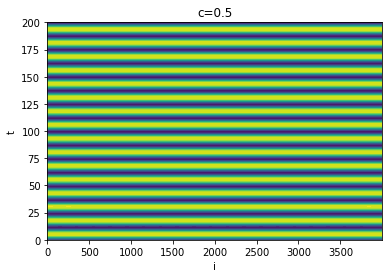

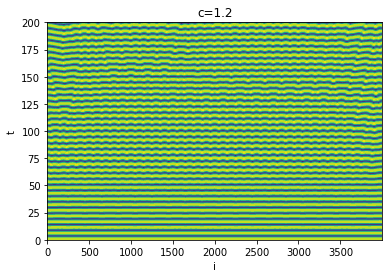

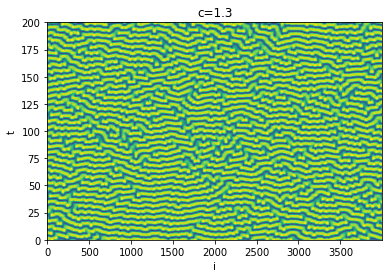

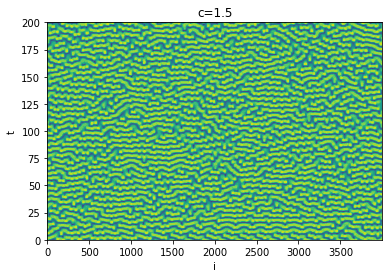

In [6]:
    #Set parameters
    beta = (25/np.pi)**2
    alpha = 1-2*beta
    b =-1.5
    n = 4000

    tf = 200
    Nt = 800

    #Set initial conidition
    L = (n-1)/np.sqrt(beta)
    k = 40*np.pi/L
    a0 = np.linspace(0,L,n)
    A0 = np.sqrt(1-k**2)*np.exp(1j*a0)
    y0 = np.zeros(2*n)
    y0[:n]=1+0.2*np.cos(4*k*a0)+0.3*np.sin(7*k*a0)+0.1*A0.real

    #---Example code for computing solution, use/modify/discard as needed---#
    c_vals = np.array([0.5, 1.2, 1.3, 1.5])
    tf_transient = [20, 20, 200, 80]
    Nt_transient = [2, 2, 4, 4]
    u_list = []
    for k, c in enumerate(c_vals):
        t,y = part3q1(y0,alpha,beta,b,c,tf=tf_transient[k],Nt=Nt_transient[k],method='RK45') #for transient, modify tf and other parameters as needed
        y0_ = y[-1,:]
        t,y = part3q1(y0_,alpha,beta,b,c,method='RK45',err=1e-6)
        u,v = y[:,:n],y[:,n:]
        u_list.append(u)


    if display:
        for k, u_ in enumerate(u_list):
            plt.figure()
            plt.contourf(np.arange(n),t,u_,20)
            plt.title(f'c={c_vals[k]}')
            plt.xlabel('i')
            plt.ylabel('t')
        #-------------------------------------------#


In [7]:
from scipy import signal

rank A: 62
f= 0.078125
dt,1/f= 0.25 12.8
rank A: 522
f= 0.1875
dt,1/f= 0.25 5.333333333333333
rank A: 800
f= 0.171875
dt,1/f= 0.25 5.818181818181818
rank A: 800
f= 0.1875
dt,1/f= 0.25 5.333333333333333


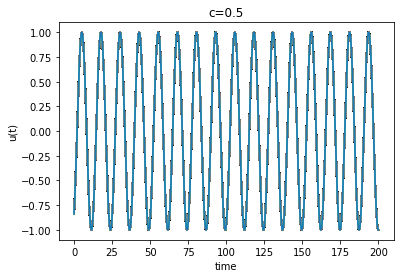

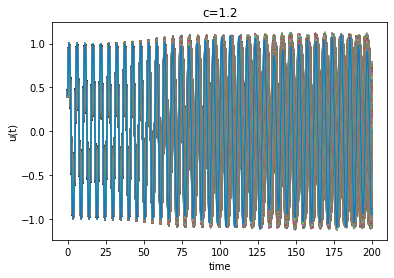

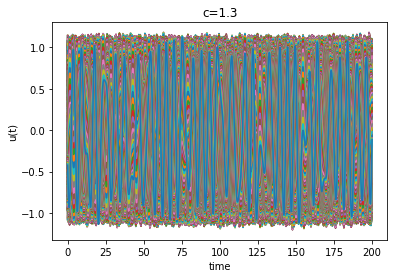

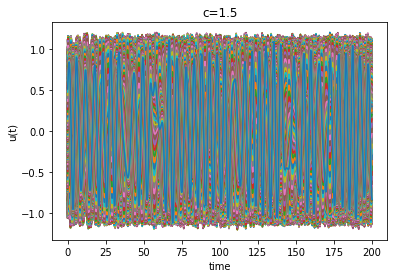

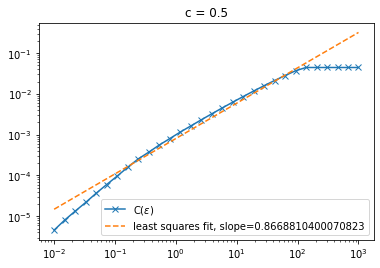

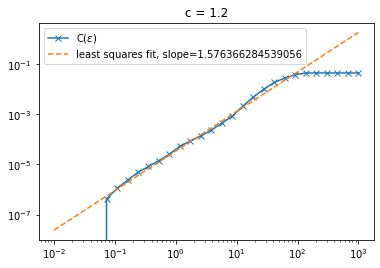

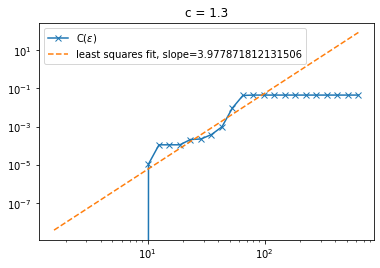

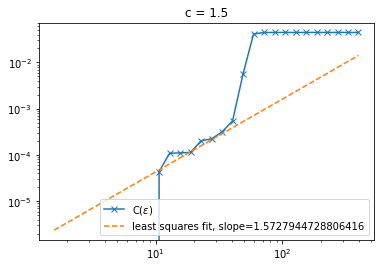

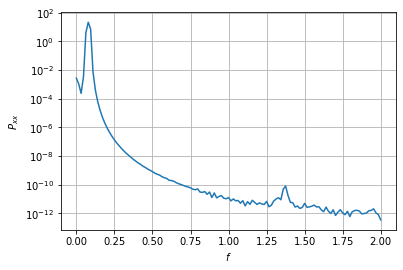

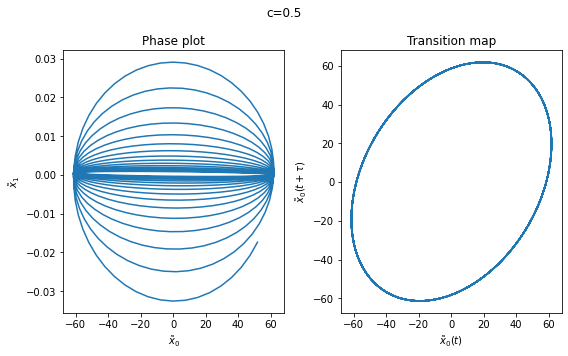

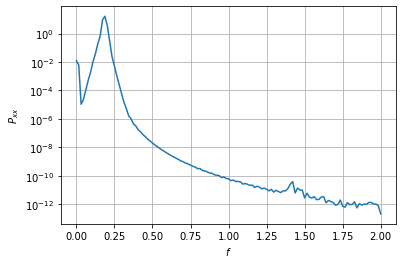

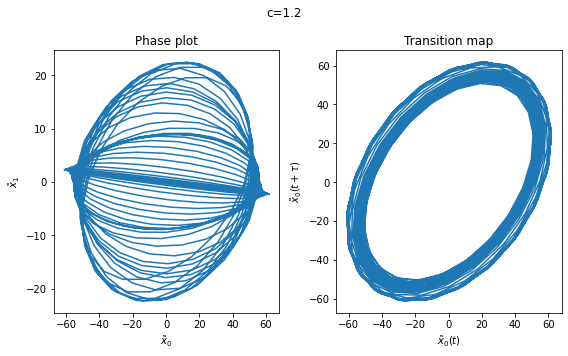

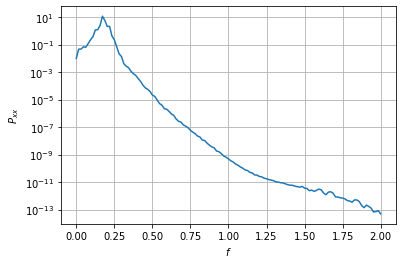

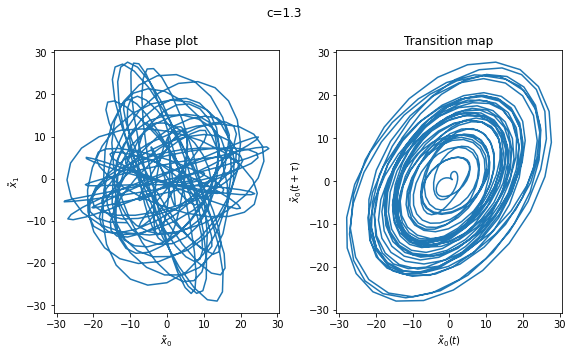

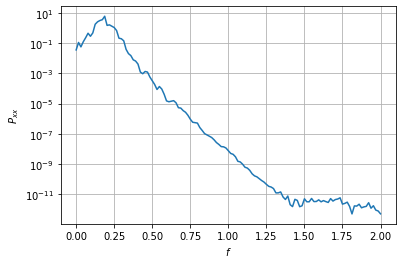

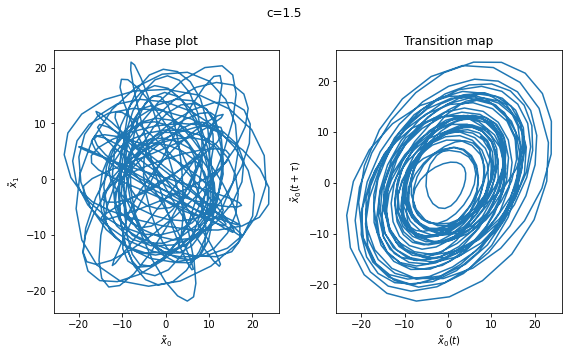

In [9]:

    #Add code here

    x_list = [u_[:,100:-99] for u_ in u_list]
    x = x_list[0]  # Further analysis on c=1.3
    Nt_1, m = x.shape

    #  Time plot
    for k, x_ in enumerate(x_list):
        plt.figure()
        for i in range(m):
            plt.plot(t, x_[:,i])
        plt.title(f'c={c_vals[k]}')
        plt.xlabel('time')
        plt.ylabel('u(t)')

    #  Correlation dimension
    def corr_dim(u, c, logeps_min, logeps_max):
        D = scipy.spatial.distance.pdist(u)
        eps = np.logspace(logeps_min-1, logeps_max+1, 30)
        C = np.array([D[D < ep].size*2/(m*(m-1)) for ep in eps])

        plt.figure()
        plt.loglog(eps, C, marker = 'x', label=r'C($\epsilon$)')
        
        eps_fit = np.logspace(logeps_min, logeps_max, 20)
        C_fit = np.array([D[D < ep].size*2/(n*(n-1)) for ep in eps_fit])
        d, p_corr = np.polyfit(np.log(eps_fit), np.log(C_fit), 1)

        plt.loglog(eps, np.exp(p_corr)*(eps**d), linestyle='--', label=f'least squares fit, slope={d}')
        plt.title(f'c = {c}')
        plt.legend()
        
    c_num = len(c_vals)
    logeps_min_vals = [-1, -1, 1.2, 1.2]
    logeps_max_vals = [2, 2, 1.8, 1.6]

    for i in range(c_num):
        corr_dim(x_list[i], c_vals[i], logeps_min_vals[i], logeps_max_vals[i])

    #  PCA analysis

    for i, x_ in enumerate(x_list):
        S, PC, xtilde = PCA(x_.T-np.mean(x_.T, axis=1)[:, None])
        xtilde = xtilde.T

        #  Welch's method
        dt = t[1]-t[0]
        fxx,Pxx = signal.welch(x_[:,0],fs=1/dt)
        plt.figure()
        plt.semilogy(fxx,Pxx)
        plt.xlabel(r'$f$')
        plt.ylabel(r'$P_{xx}$')
        plt.grid()
        f = fxx[Pxx==Pxx.max()][0]
        print("f=",f)
        print("dt,1/f=",t[1]-t[0],1/f)

        fig, ax = plt.subplots(1, 2, figsize=(8,5))

        #  Phase plot of first two principal component transformations
        ax[0].plot(xtilde[:,0], xtilde[:,1])
        ax[0].set_xlabel(r'$\tilde{x}_0$')
        ax[0].set_ylabel(r'$\tilde{x}_1$')
        ax[0].set_title('Phase plot')
        
        #  Transition map plot with time delays
        tau = 1/(5*f)
        Del = int(tau/dt)
        ax[1].plot(xtilde[:-Del,0], xtilde[Del:,0])
        ax[1].set_xlabel(r'$\tilde{x}_0(t)$')
        ax[1].set_ylabel(r'$\tilde{x}_0(t+\tau)$')
        ax[1].set_title('Transition map')
        
        plt.suptitle(f'c={c_vals[i]}')
        plt.tight_layout()

    plt.show()

In [93]:

#Set parameters
beta = (25/np.pi)**2
alpha = 1-2*beta
b =-1.5
n = 4000 # default 4000

tf = 200
Nt = 800

#Set initial conidition
L = (n-1)/np.sqrt(beta)
k = 40*np.pi/L
a0 = np.linspace(0,L,n)
A0 = np.sqrt(1-k**2)*np.exp(1j*a0)
y0 = np.zeros(2*n)
y0[:n]=1+0.2*np.cos(4*k*a0)+0.3*np.sin(7*k*a0)+0.1*A0.real

#---Example code for computing solution, use/modify/discard as needed---#
c_vals = np.array([0.5, 1.2, 1.3, 1.5])
u_list = []
for c in c_vals:
    t,y = part3q1(y0,alpha,beta,b,c,tf=20,Nt=2,method='RK45') #for transient, modify tf and other parameters as needed
    y0_ = y[-1,:]
    t,y = part3q1(y0_,alpha,beta,b,c,method='RK45',err=1e-6)
    u,v = y[:,:n],y[:,n:]
    u_list.append(u)
u = u_list[2]

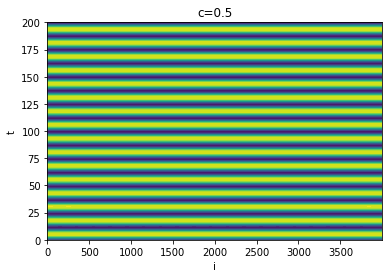

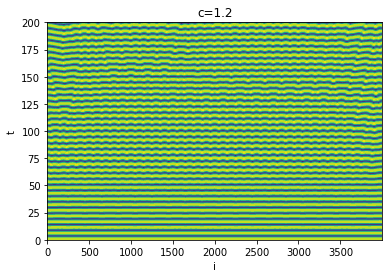

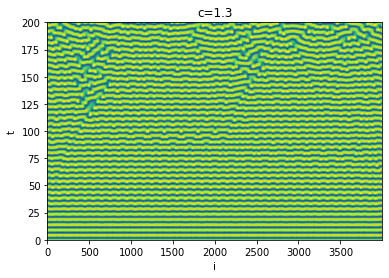

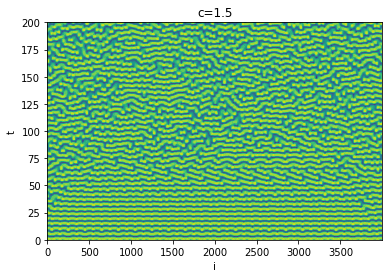

In [109]:
display = True

if display:
    for k, u_ in enumerate(u_list):
        plt.figure()
        plt.contourf(np.arange(n),t,u_,20)
        plt.title(f'c={c_vals[k]}')
        plt.xlabel('i')
        plt.ylabel('t')



In [18]:
#-------------------------------------------#

#Add code here

x = u[:,100:-99]
x_list = [u_[:,100:-99] for u_ in u_list]
Nt_1, m = x.shape
times = np.linspace(0, tf, Nt_1)


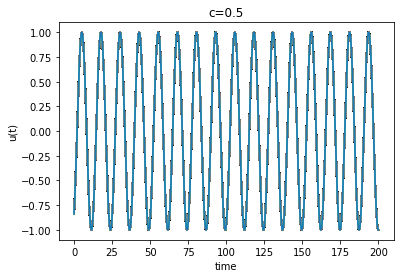

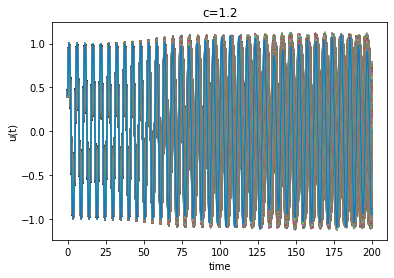

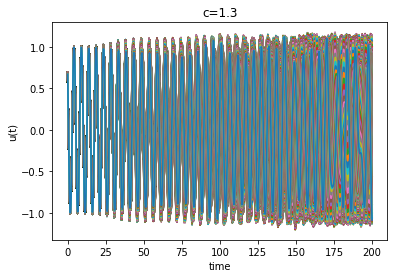

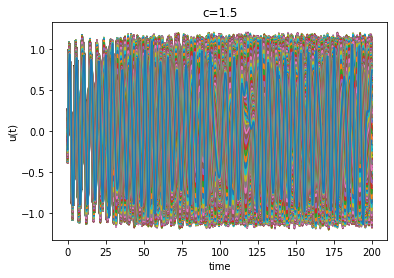

In [106]:
#  Time plot
for k, x_ in enumerate(x_list):
    plt.figure()
    for i in range(m):
        plt.plot(t, x_[:,i])
    plt.title(f'c={c_vals[k]}')
    plt.xlabel('time')
    plt.ylabel('u(t)')

Text(0, 0.5, 'u_i')

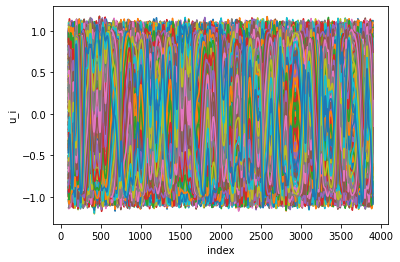

In [6]:

#  Space plot
plt.figure()
for j in range(Nt_1):
    plt.plot(np.arange(100, n-99), x[j])
plt.xlabel('index')
plt.ylabel('u_i')

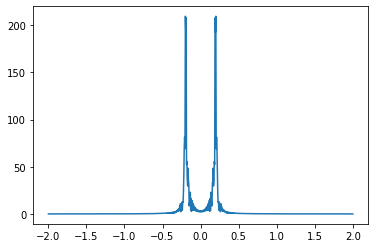

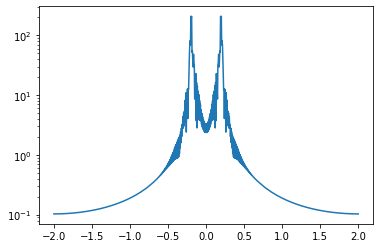

In [7]:
#  FFT analysis

Sf = np.fft.fftshift(np.abs(np.fft.fft(x, axis=0)))
f = np.fft.fftshift(np.fft.fftfreq(Nt_1, t[1]-t[0]))

plt.figure()
plt.plot(f, Sf[:, 0])
plt.figure()
plt.semilogy(f, Sf[:, 0])


2.1359552056245934


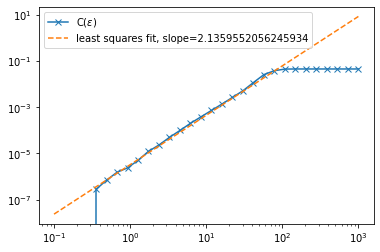

In [8]:
#  Correlation dimension

D = scipy.spatial.distance.pdist(x)
eps = np.logspace(-1, 3, 30)
C = np.array([D[D < ep].size*2/(m*(m-1)) for ep in eps])

plt.figure()
plt.loglog(eps, C, marker = 'x', label=r'C($\epsilon$)')

eps_fit = np.logspace(0, 2, 20)
C_fit = np.array([D[D < ep].size*2/(n*(n-1)) for ep in eps_fit])
d, p_corr = np.polyfit(np.log(eps_fit), np.log(C_fit), 1)
print(d)

plt.loglog(eps, np.exp(p_corr)*(eps**d), linestyle='--', label=f'least squares fit, slope={d}')
plt.legend()

0.8668810400070823
1.576366284539056
2.184257027963789
3.7615091343443074


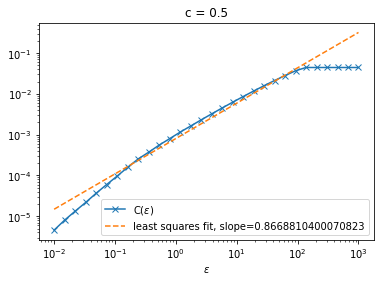

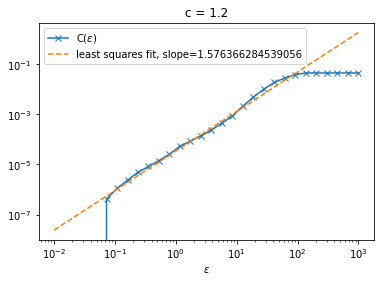

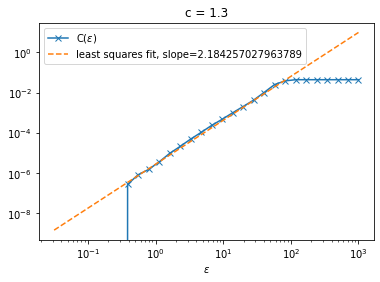

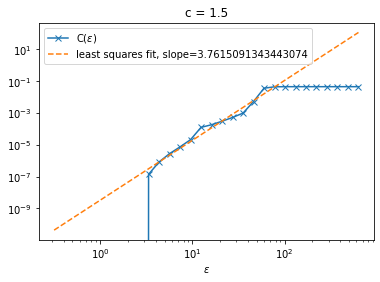

In [114]:
def corr_dim(u, c, logeps_min, logeps_max):
    D = scipy.spatial.distance.pdist(u)
    eps = np.logspace(logeps_min-1, logeps_max+1, 30)
    C = np.array([D[D < ep].size*2/(m*(m-1)) for ep in eps])

    plt.figure()
    plt.loglog(eps, C, marker = 'x', label=r'C($\epsilon$)')

    eps_fit = np.logspace(logeps_min, logeps_max, 20)
    C_fit = np.array([D[D < ep].size*2/(n*(n-1)) for ep in eps_fit])
    d, p_corr = np.polyfit(np.log(eps_fit), np.log(C_fit), 1)
    print(d)

    plt.loglog(eps, np.exp(p_corr)*(eps**d), linestyle='--', label=f'least squares fit, slope={d}')
    plt.title(f'c = {c}')
    plt.xlabel(r'$\epsilon$')
    plt.legend()

c_num = len(c_vals)
logeps_min_vals = [-1, -1, -0.5, 0.5]
logeps_max_vals = [2, 2, 2, 1.8]

for i in range(c_num):
    corr_dim(x_list[i], c_vals[i], logeps_min_vals[i], logeps_max_vals[i])
    

rank A: 62
c= 1.5
f= 0.078125
dt,1/f= 0.25 12.8
10.24
rank A: 522
c= 1.5
f= 0.1875
dt,1/f= 0.25 5.333333333333333
4.266666666666667
rank A: 681
c= 1.5
f= 0.1875
dt,1/f= 0.25 5.333333333333333
4.266666666666667
rank A: 800
c= 1.5
f= 0.1875
dt,1/f= 0.25 5.333333333333333
4.266666666666667


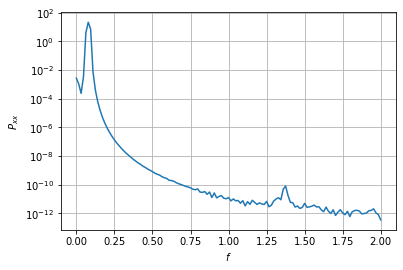

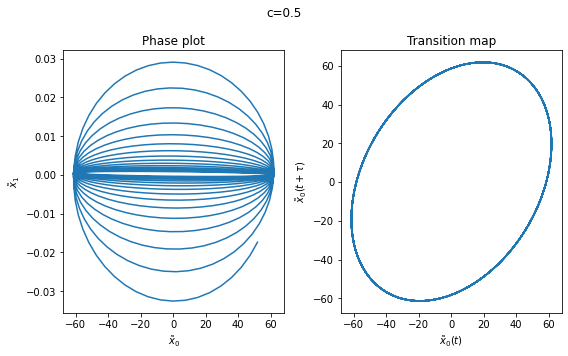

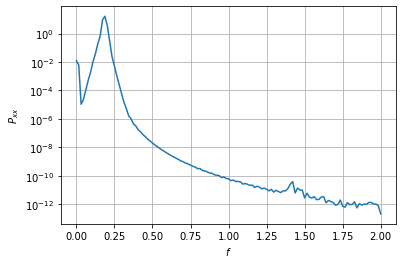

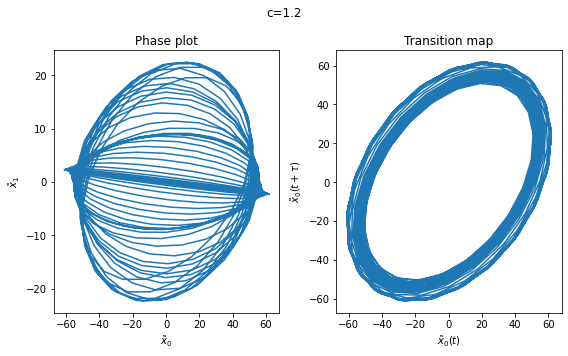

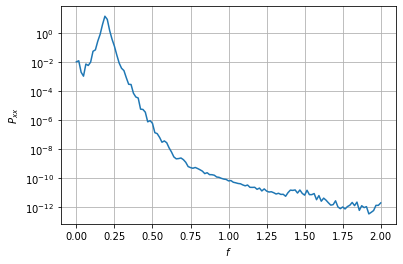

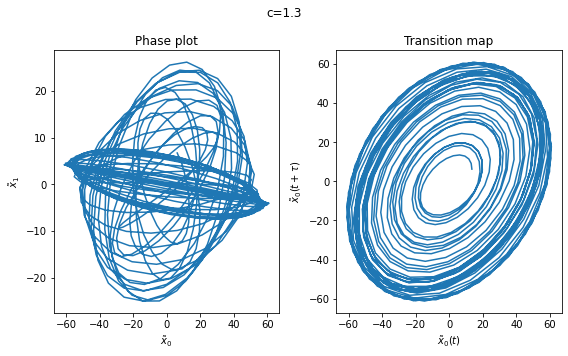

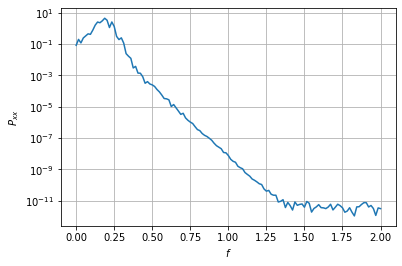

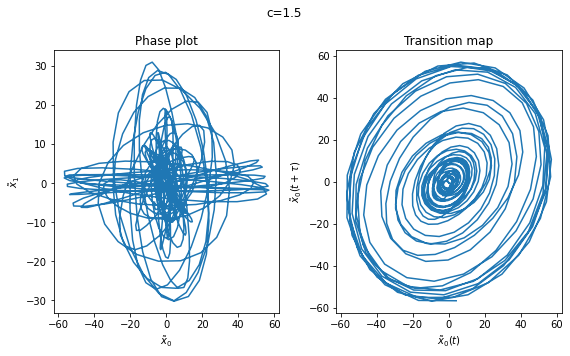

In [115]:
from scipy import signal

for i, x_ in enumerate(x_list):
    S, PC, xtilde = PCA(x_.T-np.mean(x_.T, axis=1)[:, None])
    xtilde = xtilde.T

    #  Welch's method
    dt = t[1]-t[0]
    fxx,Pxx = signal.welch(x_[:,0],fs=1/dt)
    plt.figure()
    plt.semilogy(fxx,Pxx)
    plt.xlabel(r'$f$')
    plt.ylabel(r'$P_{xx}$')
    plt.grid()
    f = fxx[Pxx==Pxx.max()][0]
    print("c=",c)
    print("f=",f)
    print("dt,1/f=",t[1]-t[0],1/f)


    fig, ax = plt.subplots(1, 2, figsize=(8,5))

    #  Phase plot of first two principal component transformations
    ax[0].plot(xtilde[:,0], xtilde[:,1])
    ax[0].set_xlabel(r'$\tilde{x}_0$')
    ax[0].set_ylabel(r'$\tilde{x}_1$')
    ax[0].set_title('Phase plot')
    
    #  Transition map plot with time delays
    tau = 1/(5*f)
    Del = int(tau/dt)
    ax[1].plot(xtilde[:-Del,0], xtilde[Del:,0])
    ax[1].set_xlabel(r'$\tilde{x}_0(t)$')
    ax[1].set_ylabel(r'$\tilde{x}_0(t+\tau)$')
    ax[1].set_title('Transition map')
    
    plt.suptitle(f'c={c_vals[i]}')
    plt.tight_layout()



(3801, 801)
(62, 3801)
(801, 62)


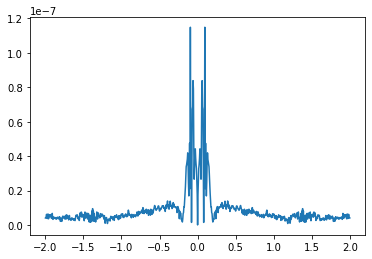

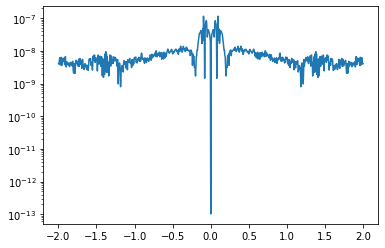

In [64]:
#  FFT analysis


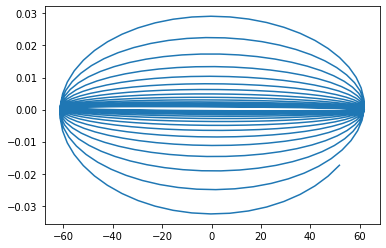

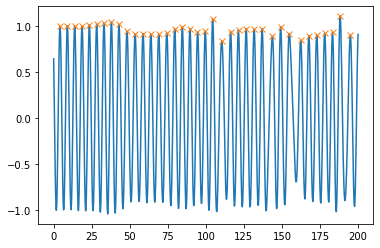

In [10]:
#  Finding max

dx = np.diff(x[:,0])
d2x  = dx[:-1]*dx[1:]
ind_max = np.argwhere(d2x<0)
x_max = x[ind_max[1::2]+1,0]

plt.figure()
plt.plot(t, x[:,0])
plt.plot(t[ind_max[1::2]+1], x_max, 'x')


In [ ]:
#  Orbit diagram for oscillations

plt.plot(x)

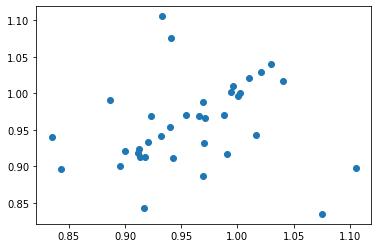

In [11]:
#  Unimodal mapping

plt.scatter(x_max[:-1,0], x_max[1:,0])

In [48]:
def part3q2(x,c=1.0):

    """
    Code for part 3, question 2
    """
    #Set parameters
    beta = (25/np.pi)**2
    alpha = 1-2*beta
    b =-1.5
    n = 4000

    #Set initial conidition
    L = (n-1)/np.sqrt(beta)
    k = 40*np.pi/L
    a0 = np.linspace(0,L,n)
    y0 = np.zeros(2*n)
    A0 = np.sqrt(1-k**2)*np.exp(1j*a0)

    y0[:n]=1+0.2*np.cos(4*k*a0)+0.3*np.sin(7*k*a0)+0.1*A0.real

    #Compute solution
    t,y = part3q1(y0,alpha,beta,b,c,tf=20,Nt=2,method='RK45') #for transient, modify tf and other parameters as needed
    y0 = y[-1,:]
    t,y = part3q1(y0,alpha,beta,b,c,method='RK45',err=1e-6)
    A = y[:,:n]
    
    print(A)

    #Analyze code here
    l1,v1 = np.linalg.eigh(A.T.dot(A))
    v2 = A.dot(v1)
    A2 = (v2[:,:x]).dot((v1[:,:x]).T)
    e = np.sum((A2.real-A)**2)

    return A2.real,e

In [50]:
part3q2(1000)

[[ 0.40469134  0.40435514  0.40404354 ...  0.40571871  0.40537419
   0.4050215 ]
 [ 0.16573166  0.16537716  0.16500814 ...  0.16690128  0.16649493
   0.16612175]
 [-0.08351611 -0.08390114 -0.08426955 ... -0.08231299 -0.08272076
  -0.0831255 ]
 ...
 [ 0.4240233   0.42426117  0.42486577 ...  0.42546551  0.42462889
   0.42414599]
 [ 0.62733728  0.62745711  0.62788993 ...  0.62881913  0.62802124
   0.6275253 ]
 [ 0.79258929  0.79260699  0.79284882 ...  0.79398552  0.79328063
   0.79282483]]


(array([[ 0.00000000e+00,  1.30501324e-07,  1.28433397e-07, ...,
         -2.86418153e-08, -1.20388572e-08, -1.22089313e-08],
        [ 0.00000000e+00, -8.88603074e-08, -6.94365168e-08, ...,
          6.88228378e-09,  2.10695011e-08, -2.37001542e-10],
        [ 0.00000000e+00,  1.62495249e-08, -1.25168201e-08, ...,
          2.82186475e-08,  4.35612973e-08,  3.18411056e-08],
        ...,
        [ 0.00000000e+00, -6.41244506e-08, -7.29410219e-08, ...,
          5.03877605e-08,  8.00345362e-08,  5.39833768e-08],
        [ 0.00000000e+00,  1.94824654e-07,  2.10196794e-07, ...,
         -5.30654182e-08, -7.78693485e-08, -5.36992436e-08],
        [ 0.00000000e+00, -2.60610892e-07, -2.36116632e-07, ...,
          5.57046280e-08,  4.40391136e-08,  3.97371524e-08]]),
 1596419.2407974128)